In [1]:
import random
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
import botorch

sns.set(style='whitegrid', font_scale=1.75)

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
import torchsort

import sys
sys.path.insert(0, '..')
from experiments.std_bayesopt.helpers import *

In [3]:
import botorch

from scipy import stats

from botorch.fit import fit_gpytorch_model
from botorch.acquisition.analytic import (
    ExpectedImprovement,
    NoisyExpectedImprovement,
    UpperConfidenceBound,
)
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
    qUpperConfidenceBound,
)
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.optim.optimize import optimize_acqf
from botorch.sampling import IIDNormalSampler, SobolQMCNormalSampler

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval

from experiments.std_bayesopt.ratio_estimation import RatioEstimator
from experiments.std_bayesopt.helpers import (
    assess_coverage,
    construct_conformal_bands,
    conf_mask_to_bounds,
)
from experiments.std_bayesopt.acquisitions import conformalize_acq_fn

In [4]:
obj_fn = lambda x: np.maximum(-0.125 * x ** 2 + 16 * np.sin(x), 0)

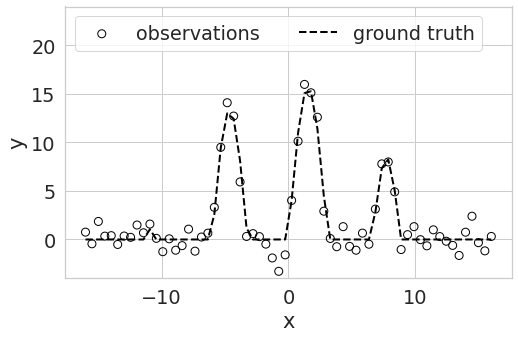

In [5]:
fig = plt.figure(figsize=(8, 5))

noise_scale = 1.
x_bounds = torch.tensor((-16., 16.)).view(-1, 1)

x = np.linspace(*x_bounds, 64)
f = obj_fn(x)
y = f + noise_scale * np.random.randn(*f.shape)

plt.scatter(x, y, edgecolors='black', facecolors='none', label='observations', s=64, zorder=3)
plt.plot(x, f, color='black', linestyle='--', label='ground truth', linewidth=2, zorder=2)

plt.ylabel('y')
plt.xlabel('x')
plt.ylim((-4, 24))
plt.legend(loc='upper left', ncol=2)

In [6]:
from lambo.utils import DataSplit, update_splits
from lambo.optimizers.pymoo import Normalizer

cutoff = np.max(np.where(x < -8))
x_min, y_min = x.min(0), y.min(0)
x_range, y_range = x.max(0) - x_min, y.max(0) - y_min

x_norm = Normalizer(
    loc=x_min + 0.5 * x_range,
    scale=x_range / 2.,
)
y_norm = Normalizer(
    loc=y_min + 0.5 * y_range,
    scale=y_range / 2.,
)

train_x = x[:cutoff]
train_y = y[:cutoff]

all_inputs = torch.tensor(x_norm(x), device=DEVICE).view(-1, 1)
all_targets = torch.tensor(y_norm(y), device=DEVICE).view(-1, 1)
target_dim = all_targets.shape[-1]

new_split = DataSplit(
    all_inputs[:cutoff].cpu().numpy(), all_targets[:cutoff].cpu().numpy()
)
train_split, val_split, test_split = update_splits(
    train_split=DataSplit(),
    val_split=DataSplit(),
    test_split=DataSplit(),
    new_split=new_split,
    holdout_ratio=0.2
)

input_bounds = torch.tensor([-1., 1.], device=DEVICE).view(-1, 1)

In [7]:
def run_datashift_opt(splits, seed, acqf="ei"):
    def draw_plot(ax):
        std_scale = stats.norm.ppf(1 - alpha / 2.)
        # plot p(f | x, D)
        ax.plot(all_inputs.cpu(), y_hat_mean, color='blue', linewidth=1, zorder=4)
        ax.fill_between(
            all_inputs.view(-1).cpu(),
            y_hat_mean - std_scale * y_hat_std,
            y_hat_mean + std_scale * y_hat_std,
            color='blue', alpha=0.25,
            label=r'$p(y | x, \mathcal{D})$',
        )
        
        # plot C_\alpha(x)
#         ax.plot(all_inputs.view(-1).cpu(), grid_lb.view(-1).cpu(), color='blueviolet', linestyle='--')
#         ax.plot(all_inputs.view(-1).cpu(), grid_ub.view(-1).cpu(), color='blueviolet', linestyle='--')
        ax.fill_between(all_inputs.view(-1).cpu(), grid_lb.view(-1).cpu(), grid_ub.view(-1).cpu(),
                       color='blueviolet', alpha=0.125)
        ax.fill_between(all_inputs.view(-1).cpu(), conf_lb.view(-1).cpu(), conf_ub.view(-1).cpu(),
                       color='blueviolet', alpha=0.25, label=r'$\mathcal{C}_\alpha(x)$')

        # plot a(x)
#         ax.plot(all_inputs.cpu(), acq_vals, color='green', zorder=5, linewidth=2)
        ax.scatter(input_query.cpu(), target_query.cpu(), marker='x', color='red', zorder=5,
                   s=32, linewidth=2)
        
        #plot r(x)
        if density_ratio is not None:
            ax.plot(all_inputs.cpu(), density_ratio, color='darkorange', zorder=6, linewidth=2, label='r(x)')

        # plot observed
        ax.scatter(train_inputs.cpu(), train_targets.cpu(), edgecolors='black', facecolors='black', s=32, zorder=3)

        # plot true function
        ax.plot(all_inputs.cpu(), y_norm(f), color='black', linestyle='--')

        ax.set_ylim((-4., 2.))

        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$', rotation=0)
        ax.legend(ncol=2, loc='lower center')
#         ax.set_title(f't={round_idx}, alpha={alpha:0.2f}')
        return ax

    train_split, val_split, test_split = splits
    
    rx_estimator = None
    optimize_callback = None
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    sampler = IIDNormalSampler(mc_samples)
    if acqf == 'ei':
        acqf_init = lambda gp, best_f: qExpectedImprovement(
            gp,
            best_f=train_targets.max(0)[0],
            sampler=sampler
        )
    elif acqf == "nei":
        acqf_init = lambda gp, best_f: qNoisyExpectedImprovement(
            gp, X_baseline=train_inputs, sampler=sampler, prune_baseline=True
        )
    elif acqf == "ucb":
        acqf_init = lambda gp, best_f: qUpperConfidenceBound(gp, beta=1.)
    elif acqf == "kg":
        acqf_init = lambda gp, best_f: qKnowledgeGradient(
            model=gp,
            current_value=train_targets.max(),
            num_fantasies=None,
            sampler=sampler,
        )
    elif acqf == 'conformal_ei':
        def acqf_init(gp, best_f):
            acqf = qExpectedImprovement(
                        gp,
                        best_f=train_targets.max(0)[0],
                        sampler=sampler,
                    )
            return conformalize_acq_fn(acqf, alpha, temp, grid_res, max_grid_refinements, rx_estimator)
    elif acqf == "conformal_nei":
        def acqf_init(gp, best_f):
            acqf = qNoisyExpectedImprovement(
                        gp, X_baseline=train_inputs, sampler=sampler, prune_baseline=True
                    )
            return conformalize_acq_fn(acqf, alpha, temp, grid_res, max_grid_refinements, rx_estimator)
    elif acqf == "conformal_ucb":
        def acqf_init(gp, best_f):
            acqf = qUpperConfidenceBound(gp, beta=1., sampler=sampler)
            return conformalize_acq_fn(acqf, alpha, temp, grid_res, max_grid_refinements, rx_estimator)
    elif acqf == "conformal_kg":
        def acqf_init(gp, best_f):
            acqf = qKnowledgeGradient(
                model=gp,
                current_value=train_targets.max(),
                num_fantasies=None,
                sampler=sampler,
            )
            return conformalize_acq_fn(acqf, alpha, temp, grid_res, max_grid_refinements, rx_estimator)
            
    
    output_dict = {
        'f_queries': torch.empty(num_rounds + 1),
        'cred_cvrg': torch.empty(num_rounds),
        'conf_cvrg': torch.empty(num_rounds),
        'alpha': torch.empty(num_rounds),
    }
    
    for round_idx in range(num_rounds):
        train_inputs = torch.tensor(train_split[0], device=DEVICE)
        train_targets = torch.tensor(train_split[1], device=DEVICE)
        val_inputs = torch.tensor(
            np.concatenate([val_split[0], test_split[0]]), device=DEVICE
        )
        val_targets = torch.tensor(
            np.concatenate([val_split[1], test_split[1]]), device=DEVICE
        )
        
        if round_idx == 0:
            output_dict['f_queries'][0] = y_norm(train_targets.max().cpu())
        
        alpha = 1 / math.sqrt(train_inputs.size(0))
        
        # prepare ratio estimator
#         if acqf.startswith('conformal'):
#             rx_estimator = RatioEstimator(in_size=train_split.inputs.shape[-1]).to(DEVICE)
#             optimize_callback = rx_estimator.optimize_callback
#             rx_estimator.dataset._update_splits(
#                 DataSplit(train_inputs.view(-1, 1).cpu(), torch.ones(train_inputs.size(0), 1))
#             )

#         matern_gp = ConformalSingleTaskGP(
#             train_X=train_inputs,
#             train_Y=train_targets,
#             likelihood=GaussianLikelihood(noise_constraint=Interval(5e-4, 0.2)),
#             alpha=alpha,
#             temp=temp,
#             tgt_grid_res=grid_res,
#             conformal_bounds=torch.tensor([[-2., 2.]]).t(),
#             ratio_estimator=rx_estimator,
#             max_grid_refinements=max_grid_refinements,
#         ).to(DEVICE)

        matern_gp = SingleTaskGP(
            train_X=train_inputs,
            train_Y=train_targets,
            likelihood=GaussianLikelihood(noise_constraint=Interval(5e-4, 0.2)),
        ).to(DEVICE)
        mll = ExactMarginalLogLikelihood(matern_gp.likelihood, matern_gp)
        fit_gpytorch_model(mll)
        matern_gp.requires_grad_(False)
        
        acq_fn = acqf_init(matern_gp, train_targets.max())
        input_query = optimize_acqf(acq_fn, input_bounds, batch_size, num_restarts=2, raw_samples=mc_samples,
                                    options=dict(callback=optimize_callback, disp=False, ftol=1e-12))[0]
        x_query = x_norm.inv_transform(input_query.detach().cpu().numpy())
        f_query = obj_fn(x_query)
        y_query = f_query + noise_scale * np.random.randn(*f_query.shape)
        target_query = torch.tensor(y_norm(y_query), device=DEVICE)
        
        matern_gp.eval()
        with torch.no_grad():
            f_hat_dist = matern_gp(all_inputs)
            y_hat_dist = matern_gp.likelihood(f_hat_dist)
            f_hat_mean = f_hat_dist.mean.cpu()
            f_hat_std = f_hat_dist.variance.sqrt().cpu()
            y_hat_mean = f_hat_mean.cpu()
            y_hat_std = y_hat_dist.variance.sqrt().cpu()
#             acq_vals = acq_fn(all_inputs[:, None]).cpu()
            target_grid, conf_pred_mask, _ = construct_conformal_bands(
                matern_gp, all_inputs[:, None], alpha, temp=1e-6,
                grid_res=grid_res, max_grid_refinements=max_grid_refinements
            )
            grid_lb = target_grid.min(-3)[0]
            grid_ub = target_grid.max(-3)[0]
            conf_lb, conf_ub = conf_mask_to_bounds(target_grid, conf_pred_mask)
            cred_cvrg, conf_cvrg = assess_coverage(
                matern_gp, val_inputs, val_targets, alpha, temp=1e-6,
                grid_res=grid_res, max_grid_refinements=max_grid_refinements
            )
        
        output_dict['f_queries'][round_idx + 1] = y_norm(f_query.max()).item()
        output_dict['cred_cvrg'][round_idx] = cred_cvrg
        output_dict['conf_cvrg'][round_idx] = conf_cvrg
        output_dict['alpha'][round_idx] = alpha
        
        density_ratio = None
        if rx_estimator is not None:
            density_ratio = rx_estimator(all_inputs).cpu()
            density_ratio /= density_ratio.sum()

        new_split = DataSplit(
            input_query.reshape(-1, 1).cpu(),
            target_query.reshape(-1, 1).cpu(),
        )
        train_split, val_split, test_split = update_splits(
            train_split, val_split, test_split, new_split, holdout_ratio=0.2
        )
#         if acqf.startswith('conformal'):
#             rx_estimator.dataset._update_splits(
#                 DataSplit(input_query.reshape(-1, 1).cpu(), torch.ones(1, 1)))

        if round_idx % plot_interval == 0:
            print(f'{train_split[0].shape[0]} train, {val_split[0].shape[0]} val, {test_split[0].shape[0]} test')
            if rx_estimator is not None:
                print(f'[Iterates] {rx_estimator.dataset.cls_train_split[0].shape[0]} train, {rx_estimator.dataset.cls_val_split[0].shape[0]} val, {rx_estimator.dataset.cls_test_split[0].shape[0]} test')
            fig = plt.figure(figsize=(8, 5))
            ax = fig.add_subplot(1, 1, 1)
            draw_plot(ax)
            plt.tight_layout()
            if save_figs:
                plt.savefig(f'./figures/synth-example_prediction-sets_seed-{seed}_round-{round_idx}.pdf')

    plt.show()

    return output_dict

### Global settings

In [8]:
num_trials = 4
mc_samples = 16
grid_res = 128
temp = 1e-2
max_grid_refinements = 1
num_rounds = 16
batch_size = 2
plot_interval = 4
save_figs = False

12 train, 2 val, 3 test
17 train, 4 val, 4 test
23 train, 4 val, 6 test
29 train, 4 val, 8 test


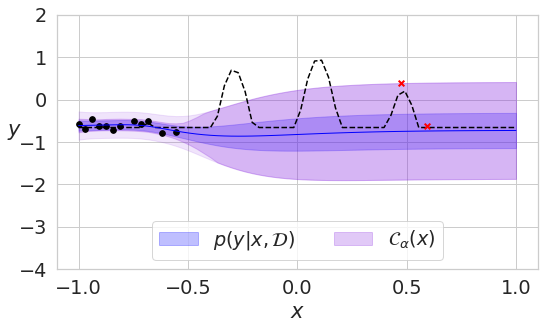

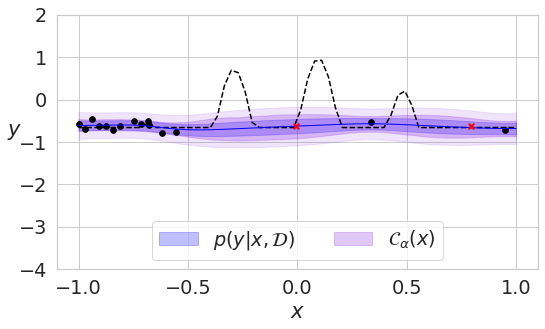

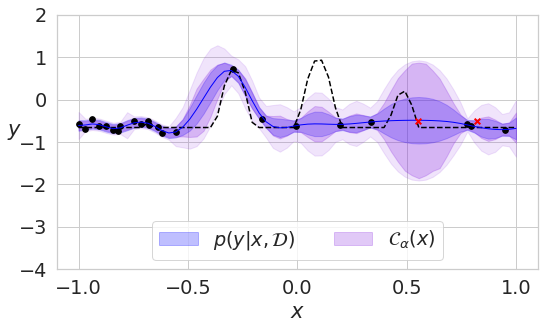

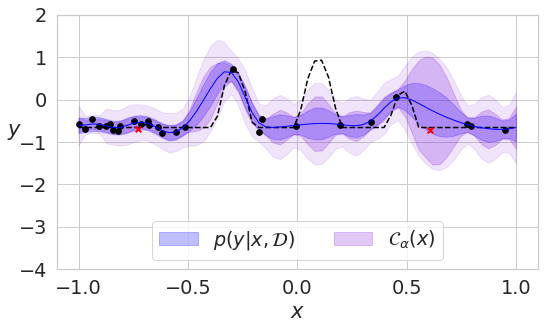

12 train, 4 val, 1 test
18 train, 4 val, 3 test
24 train, 4 val, 5 test
30 train, 6 val, 5 test


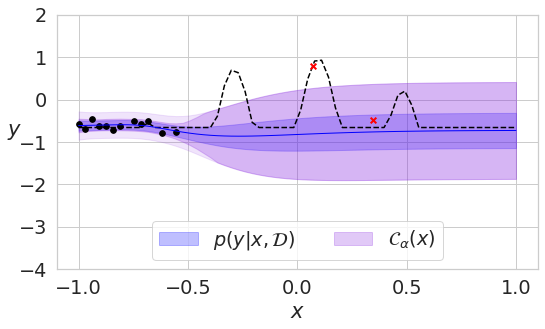

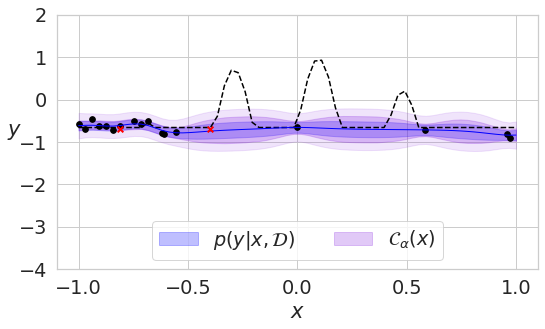

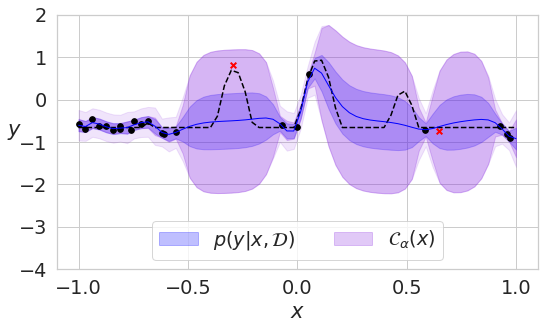

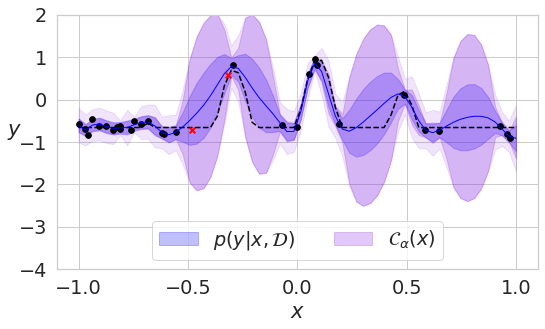

12 train, 2 val, 3 test
19 train, 2 val, 4 test
26 train, 3 val, 4 test
28 train, 6 val, 7 test


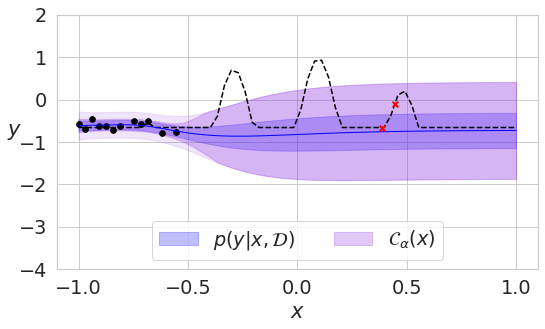

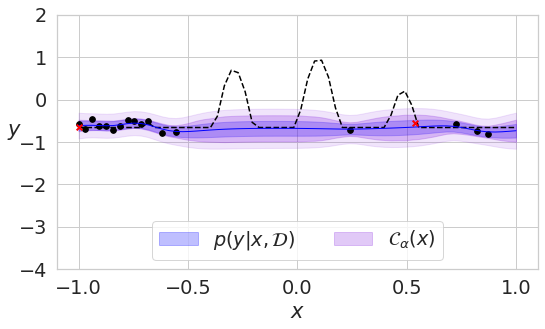

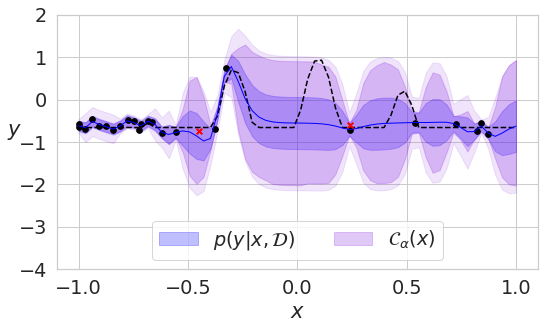

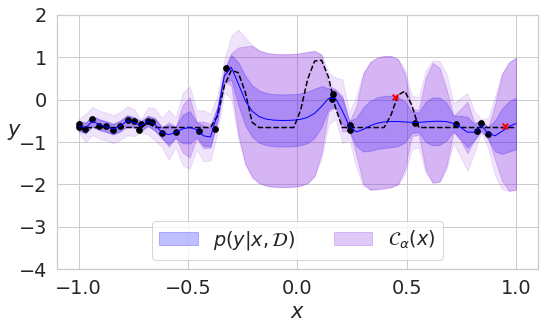

14 train, 2 val, 1 test
20 train, 3 val, 2 test
26 train, 3 val, 4 test
32 train, 4 val, 5 test


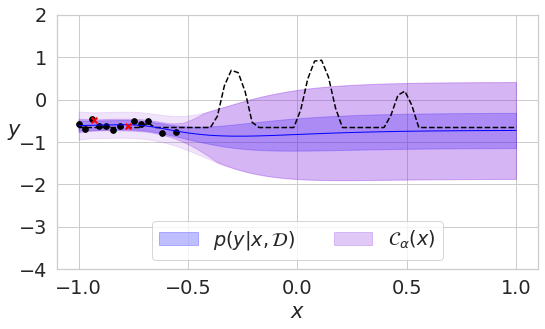

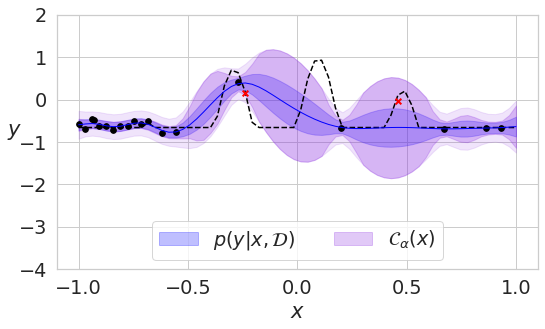

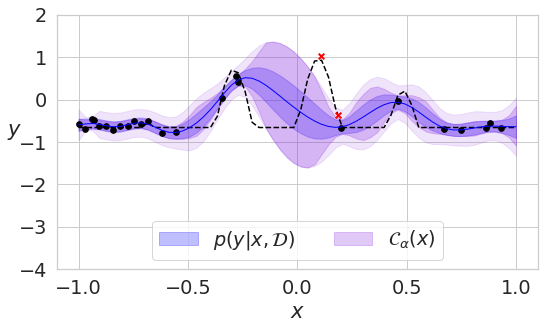

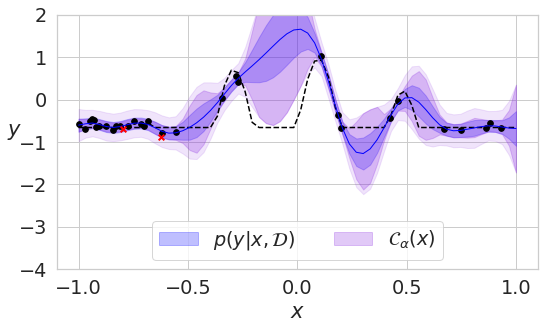

In [9]:
conformal_out = [
    run_datashift_opt(
        [train_split, val_split, test_split], seed, acqf="conformal_kg"
    ) for seed in range(num_trials)
]

12 train, 2 val, 3 test
17 train, 4 val, 4 test
23 train, 4 val, 6 test
29 train, 4 val, 8 test


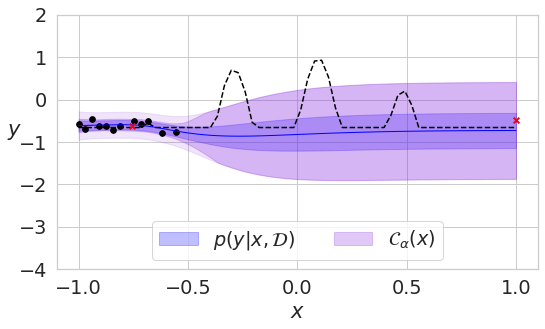

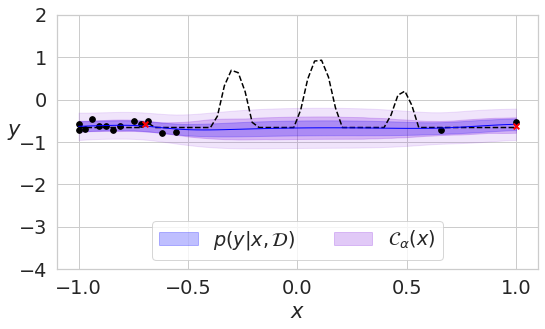

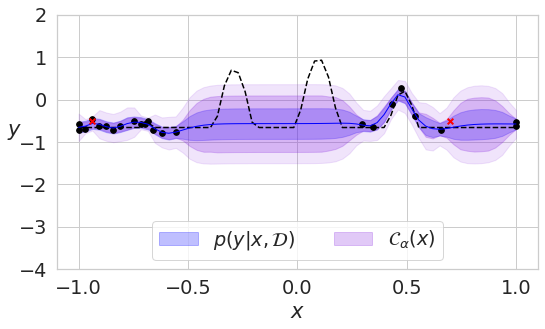

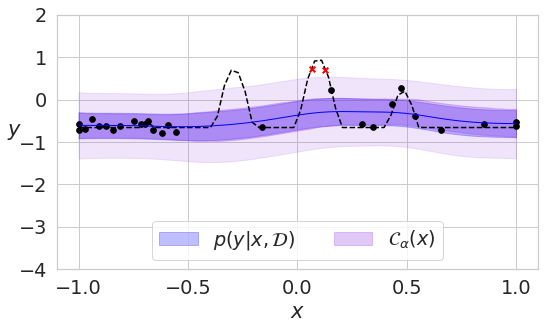

12 train, 4 val, 1 test
18 train, 4 val, 3 test
24 train, 4 val, 5 test
30 train, 6 val, 5 test


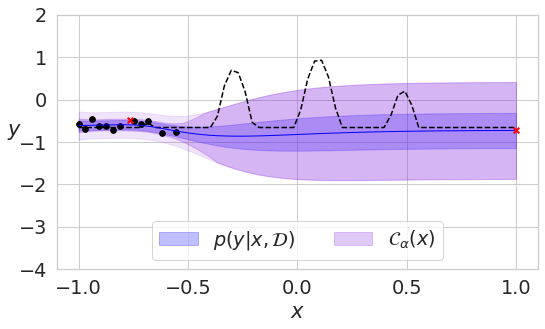

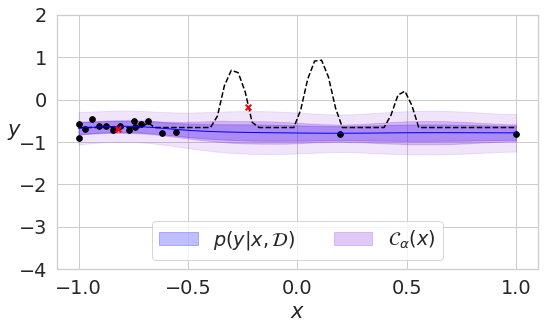

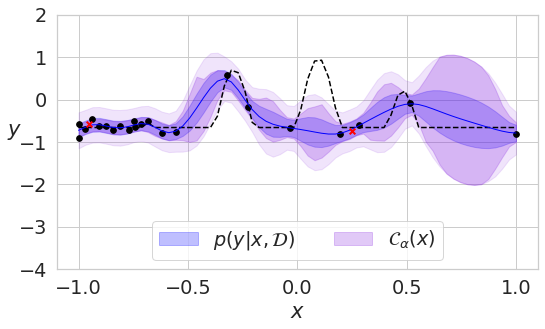

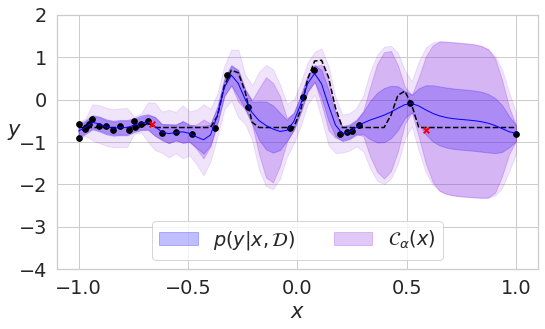

12 train, 2 val, 3 test
19 train, 2 val, 4 test
26 train, 3 val, 4 test
28 train, 6 val, 7 test


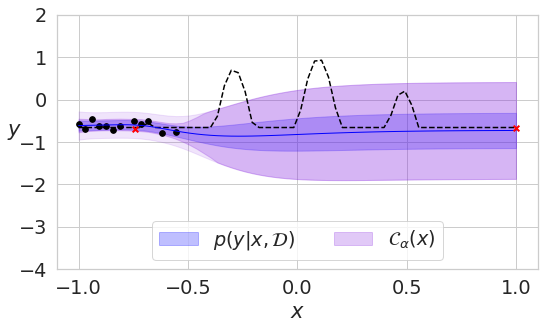

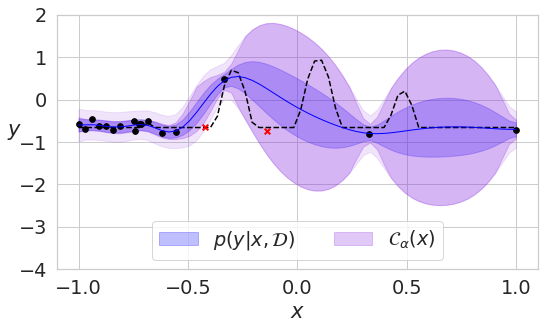

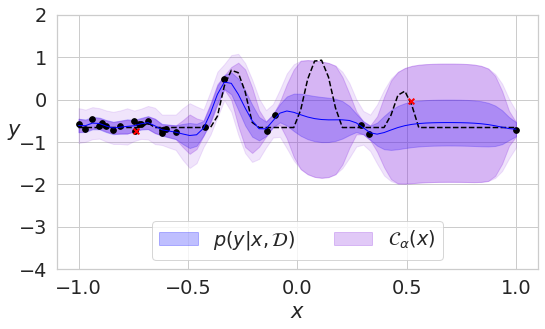

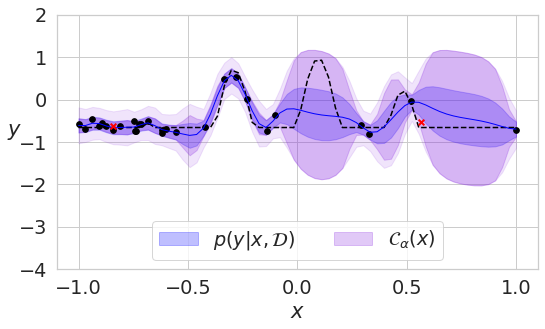

14 train, 2 val, 1 test
20 train, 3 val, 2 test
26 train, 3 val, 4 test
32 train, 4 val, 5 test


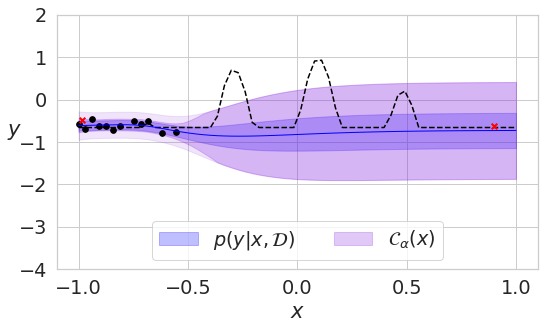

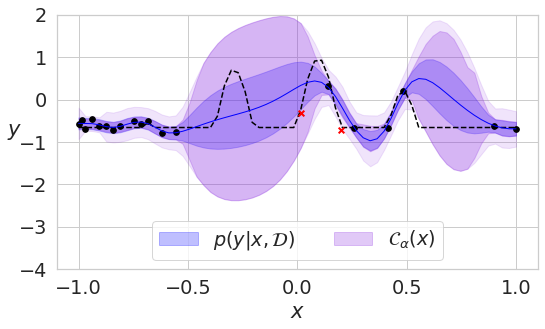

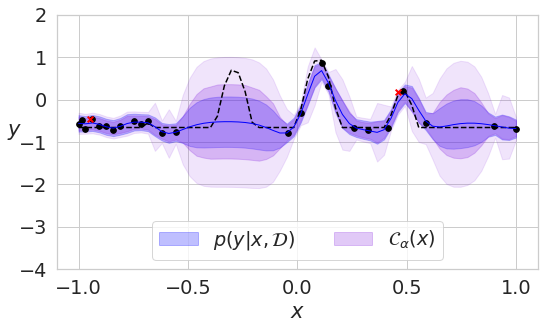

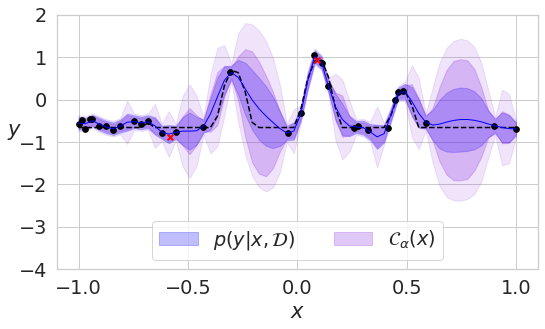

In [10]:
std_out = [
    run_datashift_opt(
        [train_split, val_split, test_split], seed, acqf="kg"
    ) for seed in range(num_trials)
]

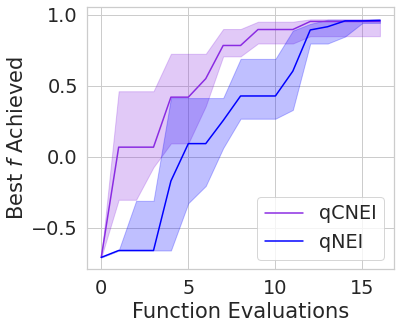

In [11]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)

conf_best_f = torch.stack([d['f_queries'] for d in conformal_out]).cummax(1)[0]
std_best_f = torch.stack([d['f_queries'] for d in std_out]).cummax(1)[0]

plt.plot(conf_best_f.quantile(0.5, dim=0), label = "qCKG", color='blueviolet')
plt.fill_between(torch.arange(conf_best_f.size(-1)), 
                 conf_best_f.quantile(0.2, dim=0), 
                 conf_best_f.quantile(0.8, dim=0), 
                 alpha = 0.25, color='blueviolet')
plt.plot(std_best_f.quantile(0.5, dim=0), label = "qKG", color='blue')
plt.fill_between(torch.arange(std_best_f.size(-1)), 
                 std_best_f.quantile(0.2, dim=0), 
                 std_best_f.quantile(0.8, dim=0), 
                 alpha = 0.25, color='blue')
plt.legend()
plt.xlabel("Function Evaluations")
plt.ylabel(r"Best $f$ Achieved")
plt.tight_layout()
# plt.savefig('./figures/synth-example_best-f.pdf')

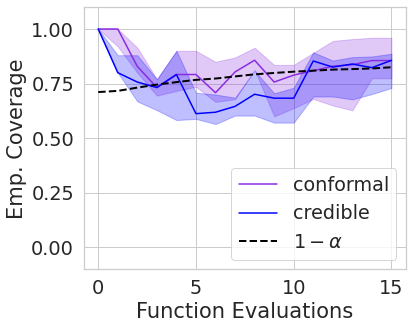

In [12]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)

conf_cvrg = torch.stack([d['conf_cvrg'] for d in conformal_out])
cred_cvrg = torch.stack([d['cred_cvrg'] for d in conformal_out])
alpha = torch.stack([d['alpha'] for d in conformal_out])

plt.plot(conf_cvrg.quantile(0.5, dim=0), label = "conformal", color='blueviolet')
plt.fill_between(torch.arange(conf_cvrg.size(-1)), 
                 conf_cvrg.quantile(0.2, dim=0), 
                 conf_cvrg.quantile(0.8, dim=0), 
                 alpha = 0.25, color='blueviolet')
plt.plot(cred_cvrg.quantile(0.5, dim=0), label = "credible", color='blue')
plt.fill_between(torch.arange(conf_cvrg.size(-1)), 
                 cred_cvrg.quantile(0.2, dim=0), 
                 cred_cvrg.quantile(0.8, dim=0), 
                 alpha = 0.25, color='blue')

plt.plot(torch.arange(alpha.size(-1)), (1 - alpha).mean(0),
         color='black', linestyle='--', linewidth=2, label=r'$1 - \alpha$')

plt.legend(ncol=1, loc='lower right')
plt.xlabel("Function Evaluations")
plt.ylabel("Emp. Coverage")
plt.ylim((-0.1, 1.1))
plt.tight_layout()
# plt.savefig('./figures/synth-example_emp-cvrg.pdf')